# 국민건강영양조사 데이터를 이용하여 우울감 예측 머신러닝 알고리즘 개발

파이썬 주피터 화면 조정

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

필요한 라이브러리 임포트

In [206]:
import os
import numpy as np
import pandas as pd
import shap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,random_split,DistributedSampler,DataLoader,TensorDataset

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score,roc_auc_score,roc_curve, classification_report, confusion_matrix, plot_roc_curve, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import rc
import seaborn as sns

현재 디렉토리 체크

In [3]:
os.getcwd()

'C:\\Users\\pc'

훈련 및 테스트에 필요한 데이터 불러오기

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [5]:
pd.set_option('display.max_seq_items', None)

등록되어 있는 데이터셋의 칼럼 이름

In [6]:
train.columns

Index(['Unnamed: 0', 'sex', 'age', 'region', 'incm', 'edu', 'occp', 'genertn',
       'allownc', 'ainc', 'marri_1', 'DI1_dg', 'DI2_dg', 'DI3_dg', 'DI5_dg',
       'DI6_dg', 'DM2_dg', 'DM3_dg', 'DJ2_dg', 'DE2_dg', 'DE1_dg', 'DC1_dg',
       'DC2_dg', 'DC3_dg', 'DC4_dg', 'DC5_dg', 'DC6_dg', 'DC7_dg', 'DF2_dg',
       'DF2_pr', 'DF2_pt', 'DL1_dg', 'DJ8_dg', 'LQ_1EQL', 'LQ_2EQL', 'LQ_3EQL',
       'LQ_4EQL', 'LQ_5EQL', 'EQ5D', 'BO1_1', 'BD1', 'mh_PHQ_S', 'BP1',
       'BP6_10', 'BP6_2', 'BP6_31', 'BS1_1', 'sm_presnt', 'BE3_85', 'BE3_86',
       'BE3_75', 'BE3_76', 'HE_BMI', 'HE_glu', 'HE_chol', 'HE_TG', 'mpa_g',
       'vpa_g'],
      dtype='object')

In [10]:
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)

피처/결과 변수 정의
 - 우울감 (mh_PHQ_S) 및 우울증 진단 여부 (DF2_pr,DF2_pt) 을 결과 변수, 그 외의 변수는 피처로 활용
 - 변수 설명은 데이터 전처리 파일 및 국민건강영양조사 데이터 설명을 참조
 - 우울감 (mh_PHQ_S) 은 2단계로 변수 정의 (정상 : 0-9, 경증~ : 10-)

In [35]:
def phq_9(x):
    if x <10:
       return 0
    else:
       return 1

train['mh_PHQ']=train['mh_PHQ_S'].apply(phq_9)
test['mh_PHQ']=test['mh_PHQ_S'].apply(phq_9)

In [ ]:
train['dep']=''

for i in range(len(train)):
    if train['DF2_pr'][i]==1 or train['DF2_pt'][i] or test['DF2_dg'][i]==1:
        train['dep'][i]=1
    else:
        train['dep'][i]=0

In [ ]:
test['dep']=''

for i in range(len(test)):
    if test['DF2_pr'][i]==1 or test['DF2_pt'][i]==1 or test['DF2_dg'][i]==1:
        test['dep'][i]=1
    else:
        test['dep'][i]=0

In [73]:
train.describe()

,sex,age,region,incm,edu,occp,genertn,allownc,ainc,marri_1,...,BE3_86,BE3_75,BE3_76,HE_BMI,HE_glu,HE_chol,HE_TG,mpa_g,vpa_g,mh_PHQ
count,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,...,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000,5180.000000
mean,1.547490,51.032239,7.589189,2.525483,2.969112,4.660618,3.541120,19.368726,475.752220,1.210618,...,0.977027,1.899035,0.327027,24.240734,101.388803,189.753861,132.042278,0.552510,0.190927,0.066795
std,0.497788,16.932927,4.981561,1.113178,1.061814,2.324071,1.664124,2.432155,335.613019,0.407787,...,1.820284,0.301312,1.108692,3.767149,22.118024,38.796147,113.076333,0.983423,0.620524,0.307243
min,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,17.000000,1.000000,...,0.000000,1.000000,0.000000,14.136286,40.000000,80.000000,24.000000,0.000000,0.000000,0.000000
25%,1.000000,38.000000,2.000000,2.000000,2.000000,2.000000,2.000000,20.000000,208.333333,1.000000,...,0.000000,2.000000,0.000000,21.721371,90.000000,164.000000,73.000000,0.000000,0.000000,0.000000
50%,2.000000,52.000000,9.000000,3.000000,3.000000,5.000000,4.000000,20.000000,416.666667,1.000000,...,0.000000,2.000000,0.000000,23.944487,96.000000,188.000000,106.000000,0.000000,0.000000,0.000000
75%,2.000000,64.000000,11.000000,4.000000,4.000000,7.000000,4.000000,20.000000,663.666667,1.000000,...,1.000000,2.000000,0.000000,26.373834,105.000000,214.000000,157.000000,1.000000,0.000000,0.000000
max,2.000000,80.000000,17.000000,4.000000,4.000000,7.000000,7.000000,20.000000,1500.000000,2.000000,...,7.000000,2.000000,7.000000,62.640542,350.000000,418.000000,2708.000000,3.000000,3.000000,2.000000


우울증 (dep) 예측 모델 구축

In [108]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5180 entries, 0 to 5179
Data columns (total 59 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sex        5180 non-null   int64  
 1   age        5180 non-null   float64
 2   region     5180 non-null   float64
 3   incm       5180 non-null   float64
 4   edu        5180 non-null   float64
 5   occp       5180 non-null   float64
 6   genertn    5180 non-null   float64
 7   allownc    5180 non-null   float64
 8   ainc       5180 non-null   float64
 9   marri_1    5180 non-null   float64
 10  DI1_dg     5180 non-null   float64
 11  DI2_dg     5180 non-null   float64
 12  DI3_dg     5180 non-null   float64
 13  DI5_dg     5180 non-null   float64
 14  DI6_dg     5180 non-null   float64
 15  DM2_dg     5180 non-null   float64
 16  DM3_dg     5180 non-null   float64
 17  DJ2_dg     5180 non-null   float64
 18  DE2_dg     5180 non-null   float64
 19  DE1_dg     5180 non-null   float64
 20  DC1_dg  

In [182]:
encoded = preprocessing.LabelEncoder()
train['dep'] = encoded.fit_transform(train['dep'])
test['dep'] = encoded.fit_transform(test['dep'])

In [183]:
X = train.drop(['dep','mh_PHQ_S','mh_PHQ','DF2_pr','DF2_pt','DF2_dg'], axis=1)
y = train['dep']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify=y)

In [184]:
X_test= test.drop(['dep','mh_PHQ_S','mh_PHQ','DF2_pr','DF2_pt','DF2_dg'], axis=1)
y_test = test['dep']

In [185]:
y_train.value_counts()

dep
0    3335
1     291
Name: count, dtype: int64

In [186]:
X_train.head(5)

,sex,age,region,incm,edu,occp,genertn,allownc,ainc,marri_1,...,BE3_85,BE3_86,BE3_75,BE3_76,HE_BMI,HE_glu,HE_chol,HE_TG,mpa_g,vpa_g
388,0,28.0,1.0,4.0,4.0,5.0,4.0,20.0,1050.000000,2.0,...,1.0,1.0,1.0,1.0,23.810865,102.0,166.0,81.0,1,1
567,1,31.0,1.0,1.0,4.0,7.0,1.0,20.0,20.000000,2.0,...,2.0,0.0,2.0,0.0,23.583355,90.0,186.0,139.0,0,0
870,1,66.0,1.0,4.0,2.0,7.0,2.0,20.0,646.333333,1.0,...,1.0,6.0,2.0,0.0,20.630149,90.0,206.0,89.0,3,0
1391,0,42.0,3.0,1.0,4.0,3.0,4.0,20.0,400.000000,1.0,...,2.0,0.0,2.0,0.0,25.461305,100.0,178.0,158.0,0,0
4326,0,54.0,14.0,1.0,3.0,6.0,1.0,20.0,83.333333,1.0,...,2.0,0.0,2.0,0.0,23.788113,95.0,213.0,78.0,0,0


Hyperparameter tuning

 (1) Grid search : 
     간단하고 광범위하게 사용되는 hyperparameter 탐색 알고리즘. 해당 범위 및 Step의 모든 경우의 수를 탐색하기 때문에
범위를 넓게 가져갈수록, Step을 작게 설정할 수록 최적 결과를 찾을 가능성이 높지만 시간이 오래 걸린다는 단점이 있음. 
일반적으로 넓은 범위와 큰 Step으로 설정한 후 범위를 좁혀 나가는 방식을 사용하여 시간을 단축함.

 (2) Random search :
     정해진 범위 내에서 Random하게 선택. 기본적으로는 더 빠르고 효율적이어서 Grid Serach보다 속도가 빠르지만 최적화된 결과는 아님.
Sample의 수가 많다면 Random Sampling을 통해 최적값을 찾을 가능성이 높으나 탐색 범위가 넓을 경우 일반화된 결과가 도출되지 못함.

 (3) Bayesian optimization :
      어느 입력값을 받는 미지의 목적 함수(objective function) 를 상정하여, 그 함숫값을 최대로 만드는 최적해를 찾는 것.
매 회 새로운 hyperparameter 값에 대한 조사를 수행할 시 ‘사전 지식’을 충분히 반영하면서, 동시에 전체적인 탐색 과정을 좀 더 체계적으로 수행하기 위해 고려해볼 수 있는 Hyperparameter Optimization 방법론임.
그러나 좋은 성능에 비해 계산 속도가 굉장히 상대적으로 느리며 오래걸림. 

Decision Tree Classifier
 - hyperparameter
 
    (1) 'criterion' : 불순도의를 측정하는 지표 종류
    
    (2) 'max_depth' : 트리의 최대 깊이
    
    (3) 'min_samples_split' : 노드를 분할하기 위한 최소한의 샘플 데이터수로, 과적합을 제어하는데 사용
    
    (4) 'min_samples_leaf' : 내부 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
    
    그 외 : criterion, n_jobs, min_impurity_split 등 있음.
    
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Randomforest classifier
 - hyperparameter
 
    (1) 'n_estimators' : 모델에서 사용할 트리 갯수(학습시 생성할 트리 갯수)
    
    (2) 'max_depth' : 트리의 최대 깊이
    
    (3) 'min_samples_leaf' : 내부 노드를 분할하는데 필요한 최소 샘플 수 (default : 2)
    
    (4) 'max_features' : 각 노드에서 분할에 사용할 특징의 최대 수
    
    그 외 : criterion, n_jobs, min_impurity_split 등 있음.
    
    (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

(1) Decision tree

In [187]:
# Define hyperparameters and their possible values for tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}

clf = DecisionTreeClassifier()

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print('DT - 최적 하이퍼 파라미터:', grid_search.best_params_)
print("RF - 최고 예측 정확도: {0:.4f}", format(grid_search.best_score_))

DT - 최적 하이퍼 파라미터: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42}
RF - 최고 예측 정확도: {0:.4f} 0.9139545929514583


In [188]:
# Create a Decision Tree classifier with the best hyperparameters
best_clf = DecisionTreeClassifier(**best_params)

# Train the classifier on the training data with the best hyperparameters
best_clf.fit(X_train, y_train)

# Make predictions
y_pred = best_clf.predict(X_val)

print('Model accuracy score (validation) with randomforest : {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model accuracy score (validation) with randomforest : 0.9163


validation 결과 비교를 통해 필요시 gridsearch 수정을 통해 다시 hyperparameter tuning

In [189]:
y_pred1 = best_clf.predict(X_test)

[Text(0, 0.5, 'Dep'), Text(0, 1.5, 'NoDep')]

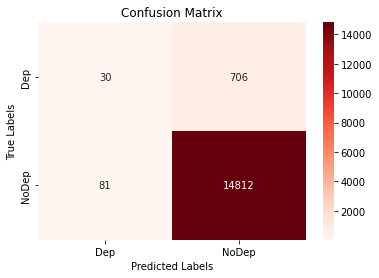

In [190]:
cm=confusion_matrix(y_test, y_pred1, labels=[1,0])
ax=plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Reds', fmt='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Dep','NoDep'])
ax.yaxis.set_ticklabels(['Dep','NoDep'])

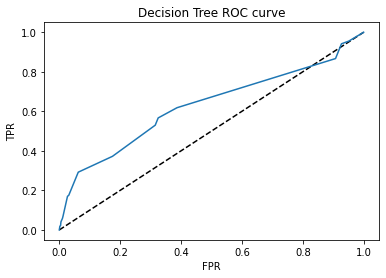

0.6278351242486258

In [192]:
fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:,1])
plt.plot([0,1], [0,1], "k--")
plt.plot(fpr, tpr, label='Decision Tree')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Decision Tree ROC curve')
plt.show()

rand_score = roc_auc_score(y_test, best_clf.predict_proba(X_test)[:,1])
rand_score

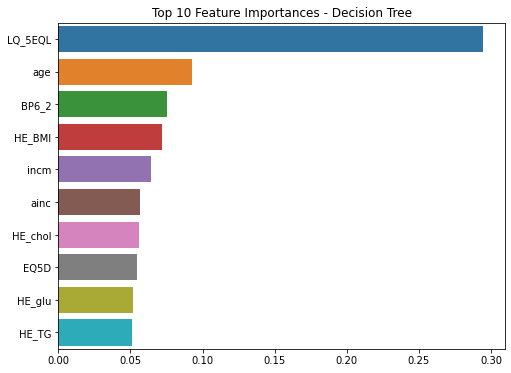

In [193]:
ftr_importances_values = best_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns).sort_values(ascending=False)

ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances - Decision Tree')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()

SHAP (Shapley Additive exPlanations)이란, 기계학습 모델의 결과를 설명하기 위한 게임 이론적인 접근 방식임. Shapley value 를 사용하여 설명가능력을 갖추어 모델의 결과를 이해할 수 있도록 도와줌.

https://github.com/slundberg/shap

In [207]:
explainer = shap.TreeExplainer(best_clf) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test)

SHAP force plot : 특정 데이터 혹은 전체 데이터에 대한 Shapley Value를 평면에 출력
 - 예측값에 긍정적 요인은 빨간색, 부정적 요인은 파란색, bar 크기가 클 수록 큰 영향력

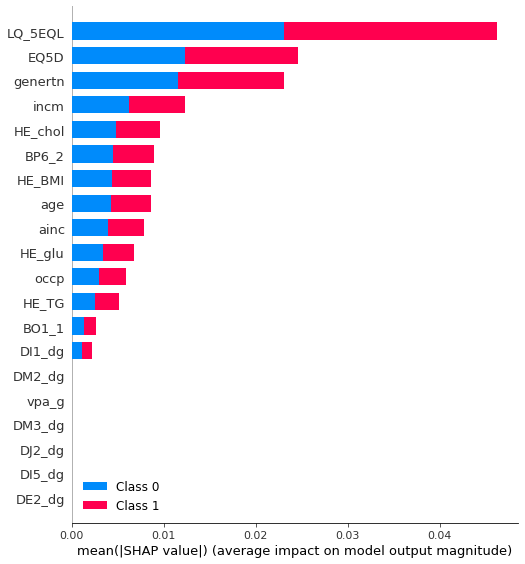

In [225]:
shap.summary_plot(shap_values, X_test)

(2) Randomforest classifier

In [196]:
params_rf = {
    'n_estimators':[100, 200, 300],
    'max_depth' : [2, 3, 4], 
    'min_samples_leaf' : [10,20,30,40],
    'max_features' : [5,10,15,20]
}
 
forest = RandomForestClassifier(random_state=1, criterion='gini', bootstrap=True, class_weight='balanced',
                                min_impurity_decrease=0.0, min_weight_fraction_leaf=0.0,
                                n_jobs=-1, oob_score=False, verbose=0, warm_start=False)

grid_cv_rf = GridSearchCV(forest, param_grid=params_rf, cv=5, n_jobs=-1)
grid_cv_rf=grid_cv_rf.fit(X_train, y_train)
 
print('RF - 최적 하이퍼 파라미터:', grid_cv_rf.best_params_)
print('RF - 최고 예측 정확도: {0:.4f}'.format(grid_cv_rf.best_score_))

RF - 최적 하이퍼 파라미터: {'max_depth': 4, 'max_features': 15, 'min_samples_leaf': 10, 'n_estimators': 200}
RF - 최고 예측 정확도: 0.8370


In [198]:
# instantiate the classifier 
rfc = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
                       max_depth=4, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=15,
                       min_samples_leaf=10, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [199]:
y_pred = rfc.predict(X_val)

In [200]:
print('Model accuracy score (validation) with randomforest : {0:0.4f}'. format(accuracy_score(y_val, y_pred)))

Model accuracy score (validation) with randomforest : 0.8340


In [201]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1429
           1       0.18      0.30      0.23       125

    accuracy                           0.83      1554
   macro avg       0.56      0.59      0.57      1554
weighted avg       0.87      0.83      0.85      1554



validation 결과 비교를 통해 필요시 gridsearch 수정을 통해 다시 hyperparameter tuning

In [202]:
y_pred1 = rfc.predict(X_test)

[Text(0, 0.5, 'Dep'), Text(0, 1.5, 'NoDep')]

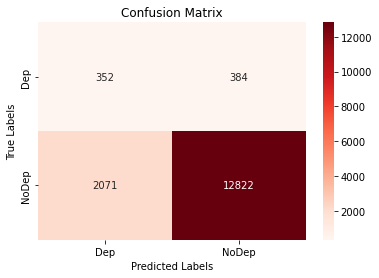

In [203]:
cm=confusion_matrix(y_test, y_pred1, labels=[1,0])
ax=plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Reds', fmt='d')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.xaxis.set_ticklabels(['Dep','NoDep'])
ax.yaxis.set_ticklabels(['Dep','NoDep'])

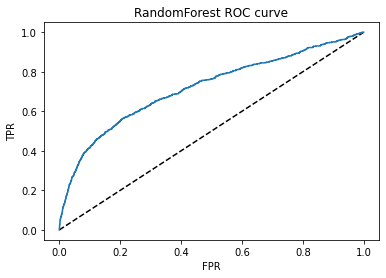

0.7174486883245411

In [204]:
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.plot([0,1], [0,1], "k--")
plt.plot(fpr, tpr, label='RandomForest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('RandomForest ROC curve')
plt.show()

rand_score = roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])
rand_score

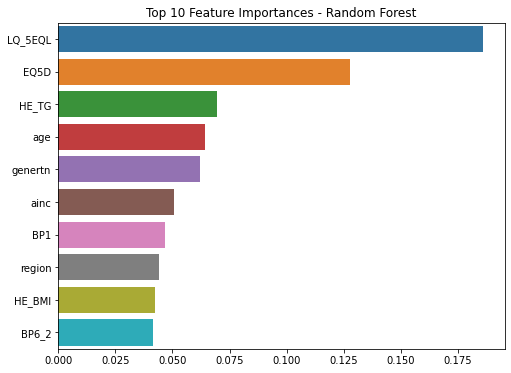

In [205]:
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns).sort_values(ascending=False)

ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,6))
plt.title('Top 10 Feature Importances - Random Forest')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()

In [226]:
explainer = shap.TreeExplainer(rfc) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test)

SHAP summary plot :전체 feature들에 대해 Shapley Value 가 어떠한 분포를 미치는지 시각화함.
 - 빨간색 : Feature 값이 높아지는 양상
 - 파란색 : Feature 값이 낮아지는 양상
 - X축 기준 음의 영역 : 예측에 있어 부정적 요인 (Negative impact)
 - X축 기준 양의 영역 : 예측에 있어 긍정적 요인 (Positive impact)

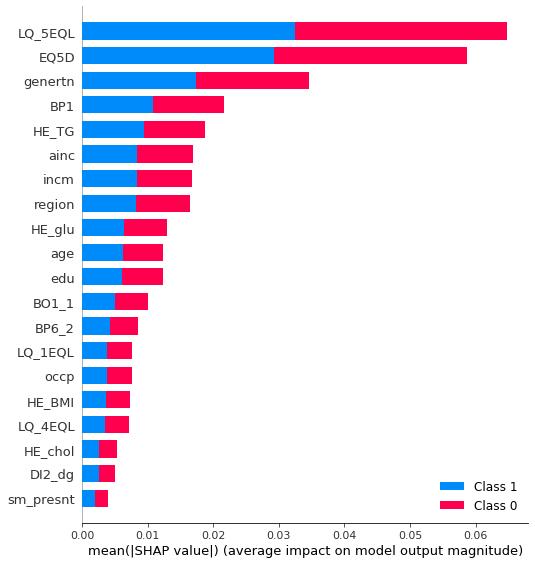

In [227]:
shap.summary_plot(shap_values, X_test)

SHAP force plot : 특정 데이터 혹은 전체 데이터에 대한 Shapley Value를 평면에 출력
 - 예측값에 긍정적 요인은 빨간색, 부정적 요인은 파란색, bar 크기가 클 수록 큰 영향력

- 우울증(dep)이 아닌 우울감(phq-9)으로 결과 변수 설정 후 모델링
- 다른 머신러닝 모델 도입을 통해 더 높은 성능 도출 